In [6]:
# Run once (outside notebook if you want)
# pip install rasterio tqdm torch torchvision matplotlib

import os
import re
import glob
import numpy as np
import torch
import rasterio
from rasterio.errors import RasterioIOError
from datetime import datetime, date
from tqdm import tqdm
import matplotlib.pyplot as plt


In [7]:
def extract_date_from_tif(path):
    """Extract acquisition date from metadata or filename."""
    try:
        with rasterio.open(path) as src:
            tags = src.tags()
            for key in (
                "DATE_ACQUIRED","ACQUISITION_DATE","SENSING_TIME",
                "TIFFTAG_DATETIME","ACQUISITION"
            ):
                if key in tags and tags[key]:
                    s = tags[key]
                    for fmt in (
                        "%Y-%m-%d",
                        "%Y:%m:%d %H:%M:%S",
                        "%Y-%m-%dT%H:%M:%S",
                        "%Y%m%d",
                        "%Y-%m-%d %H:%M:%S"
                    ):
                        try:
                            dt = datetime.fromisoformat(s) if 'T' in s else datetime.strptime(s, fmt)
                            return dt.date()
                        except Exception:
                            pass
    except RasterioIOError:
        pass

    fname = os.path.basename(path)
    m = re.search(r'(\d{4}-\d{2}-\d{2})', fname)
    if m:
        return datetime.strptime(m.group(1), "%Y-%m-%d").date()
    m = re.search(r'(\d{8})', fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()

    return None


def detect_cloud_band(path):
    """Detect cloud / QA band heuristically."""
    try:
        with rasterio.open(path) as src:
            if src.descriptions:
                for i, d in enumerate(src.descriptions):
                    if d and any(k in d.lower() for k in ["cloud", "qa", "mask", "fmask"]):
                        return i + 1
            for i in range(1, src.count + 1):
                arr = src.read(i, window=rasterio.windows.Window(0, 0, 200, 200))
                if len(np.unique(arr)) <= 4:
                    return i
    except Exception:
        pass
    return None


def read_tif_all_bands(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        profile = src.profile
        desc = src.descriptions
    return arr, profile, desc


In [8]:
def build_sequence_for_patch(root_s2_folder, patch_id, num_steps=None):
    """
    root_s2_folder: .../ROIs2017/117/S2
    patch_id: int (0–283)
    """

    tif_paths = []

    # Loop over time folders 0..29
    for t in sorted(os.listdir(root_s2_folder), key=lambda x: int(x)):
        time_dir = os.path.join(root_s2_folder, t)
        if not os.path.isdir(time_dir):
            continue

        matches = glob.glob(
            os.path.join(time_dir, f"*patch_{patch_id}.tif")
        )
        tif_paths.extend(matches)

    if len(tif_paths) == 0:
        raise FileNotFoundError(f"No files found for patch {patch_id}")

    # Extract dates and sort temporally
    files_dates = [(p, extract_date_from_tif(p)) for p in tif_paths]
    files_dates = sorted(files_dates, key=lambda x: x[1] or date.min)

    paths = [p for p, _ in files_dates]
    dates = [d for _, d in files_dates]

    # Target = latest timestamp
    target_path = paths[-1]
    target_date = dates[-1]

    seq_paths = paths[:-1]
    seq_dates = dates[:-1]

    if num_steps is not None:
        seq_paths = seq_paths[-num_steps:]
        seq_dates = seq_dates[-num_steps:]

    arr_t, prof_t, _ = read_tif_all_bands(target_path)
    cband = detect_cloud_band(target_path)

    T_list, Mx_list, Cx_list, delta_list = [], [], [], []

    for p, d in zip(seq_paths, seq_dates):
        arr, profile, _ = read_tif_all_bands(p)

        if cband and cband <= arr.shape[0]:
            cloud = arr[cband - 1]
            others = np.delete(arr, cband - 1, axis=0)
        else:
            cloud = np.zeros_like(arr[0])
            others = arr

        Mx = (~np.isnan(others)).all(axis=0).astype(np.float32)[None]
        others = others / max(np.nanmax(others), 1.0)

        Cx = np.stack([(cloud > 0).astype(np.float32),
                       np.zeros_like(cloud)], axis=0)

        T_list.append(others)
        Mx_list.append(Mx)
        Cx_list.append(Cx)

        delta = abs((target_date - d).days) if d else 9999
        delta_list.append([delta])

    T = np.stack(T_list)
    Mx = np.stack(Mx_list)
    Cx = np.stack(Cx_list)
    delta_days = np.array(delta_list, dtype=np.float32)

    # Target masks
    if cband and cband <= arr_t.shape[0]:
        cloud_t = arr_t[cband - 1]
        other_t = np.delete(arr_t, cband - 1, axis=0)
    else:
        cloud_t = np.zeros_like(arr_t[0])
        other_t = arr_t

    My = (~np.isnan(other_t)).all(axis=0)[None, None]
    Cy = np.stack([(cloud_t > 0).astype(np.float32),
                   np.zeros_like(cloud_t)], axis=0)[None]

    return {
        "T": T,
        "Mx": Mx,
        "Cx": Cx,
        "delta_days": delta_days,
        "My": My.astype(np.float32),
        "Cy": Cy.astype(np.float32),
        "seq_paths": seq_paths,
        "target_path": target_path
    }


In [9]:
# 4_algo1_module.py cell
import torch
import torch.nn as nn
import torch.nn.functional as F

class Algo1(nn.Module):
    def __init__(self, c_in, cond_channels=3, hidden_dim=32):
        """
        c_in: number of spectral channels in T
        cond_channels: channels in conditional input (My + Cy) => default 1 + 2 = 3
        hidden_dim: number of output feature maps per time step
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        # combine: (c_in) + (1 for missingness) + (2 for cloud)
        self.point_conv_combine = nn.Conv2d(c_in + 1 + 2, hidden_dim, kernel_size=1)
        # cond embedding conv to hidden dim
        self.point_conv_cond = nn.Conv2d(cond_channels, hidden_dim, kernel_size=1)
        # spatial conv 3x3 then reduce back to hidden dim via 1x1
        self.conv3 = nn.Conv2d(hidden_dim, 64, kernel_size=3, padding=1)
        self.point_conv_out = nn.Conv2d(64, hidden_dim, kernel_size=1)
        # small scale param for delta normalization (learnable)
        self.register_parameter("delta_scale", nn.Parameter(torch.tensor(30.0)))  # divide days by ~30 (months)

    def forward(self, T, Mx, Cx, delta_days, My=None, Cy=None):
        """
        T: [B, t, c_in, H, W]
        Mx: [B, t, 1, H, W]
        Cx: [B, t, 2, H, W]
        delta_days: [B, t, 1]  (days)
        My: [B, 1, H, W]  (or None)
        Cy: [B, 2, H, W]  (or None)
        Returns: X [B, t, hidden_dim, H, W]
        """
        B, t, c_in, H, W = T.shape
        # flatten time into batch for conv ops: shape => [B*t, c, H, W]
        T_flat = T.reshape(B*t, c_in, H, W)
        Mx_flat = Mx.reshape(B*t, 1, H, W)
        Cx_flat = Cx.reshape(B*t, 2, H, W)

        # normalize delta_days -> decay in (0,1]
        # delta_days shape [B,t,1] -> (B*t, 1)
        delta = delta_days.reshape(B*t, 1)
        delta_norm = delta / (torch.clamp(self.delta_scale, min=1e-6))  # e.g. months by default
        # decay = exp(-ReLU(delta_norm))
        decay = torch.exp(-F.relu(delta_norm)).view(B*t, 1, 1, 1)  # broadcastable to H,W

        Mx_decay = Mx_flat * decay  # [B*t,1,H,W]

        # combine features per time-step
        combined = torch.cat([T_flat, Mx_decay, Cx_flat], dim=1)  # [B*t, c_in+1+2, H, W]
        x = self.point_conv_combine(combined)  # [B*t, hidden_dim, H, W]

        # conditional input (My,Cy) is only available in training; if present, broadcast & add
        if (My is not None) and (Cy is not None):
            # My [B,1,H,W], Cy [B,2,H,W] -> cond [B,3,H,W]
            cond = torch.cat([My, Cy], dim=1)  # [B,3,H,W]
            cond_feat = self.point_conv_cond(cond)  # [B, hidden_dim, H, W]
            # repeat for each time step
            cond_feat_rep = cond_feat.unsqueeze(1).repeat(1, t, 1, 1, 1).reshape(B*t, self.hidden_dim, H, W)
            x = x + cond_feat_rep

        # spatial conv
        x = self.conv3(F.mish(x))
        x = self.point_conv_out(F.mish(x))  # [B*t, hidden_dim, H, W]

        # reshape back to [B, t, hidden_dim, H, W]
        out = x.reshape(B, t, self.hidden_dim, H, W)
        return out


In [10]:
root_s2 = r"D:\Sathvik Dataset\PE (Dataset for cloud removal)\ROIs2017\117\S2"

# Use ONLY 5 patches
patch_ids = [0, 1, 2, 3, 4]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = None
outputs = []

for pid in patch_ids:
    print(f"\nProcessing patch {pid}")

    seq = build_sequence_for_patch(
        root_s2_folder=root_s2,
        patch_id=pid,
        num_steps=None   # use full temporal length (0–29)
    )

    T = torch.from_numpy(seq["T"])[None].to(device)
    Mx = torch.from_numpy(seq["Mx"])[None].to(device)
    Cx = torch.from_numpy(seq["Cx"])[None].to(device)
    delta = torch.from_numpy(seq["delta_days"])[None].to(device)
    My = torch.from_numpy(seq["My"]).to(device)
    Cy = torch.from_numpy(seq["Cy"]).to(device)

    if model is None:
        model = Algo1(c_in=T.shape[2]).to(device)
        model.eval()

    with torch.no_grad():
        out = model(T, Mx, Cx, delta, My=My, Cy=Cy)

    print("Output shape:", out.shape)
    outputs.append(out.cpu())

# Stack 5 patches
outputs = torch.cat(outputs, dim=0)
print("Final stacked output:", outputs.shape)



Processing patch 0
Output shape: torch.Size([1, 29, 32, 256, 256])

Processing patch 1
Output shape: torch.Size([1, 29, 32, 256, 256])

Processing patch 2
Output shape: torch.Size([1, 29, 32, 256, 256])

Processing patch 3
Output shape: torch.Size([1, 29, 32, 256, 256])

Processing patch 4
Output shape: torch.Size([1, 29, 32, 256, 256])
Final stacked output: torch.Size([5, 29, 32, 256, 256])


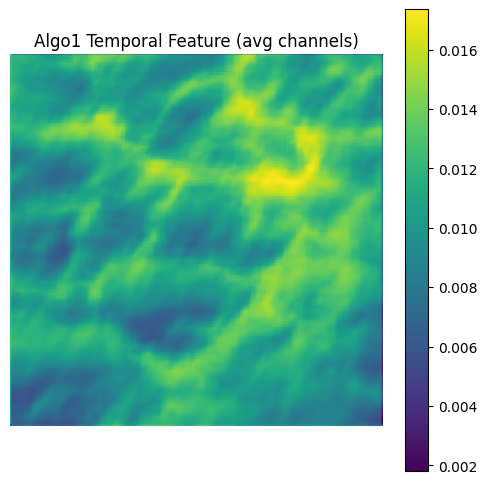

In [11]:
feat = out[0, 0].cpu().numpy()
img = feat.mean(axis=0)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="viridis")
plt.colorbar()
plt.title("Algo1 Temporal Feature (avg channels)")
plt.axis("off")
plt.show()


In [12]:
# ============================================================
# STAGE-2: TIMEGATE TEMPORAL AGGREGATION (CORRECT PAPER VERSION)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeGateAggregator(nn.Module):
    def __init__(self, hidden_dim=32, out_channels=13):
        super().__init__()
        
        # Score network for each timestep (GAP → FC → score e_i)
        self.score_fc = nn.Linear(hidden_dim, 1)

        # Converts aggregated feature map → 13-band image
        self.out_conv = nn.Conv2d(hidden_dim, out_channels, kernel_size=1)

    def forward(self, X):
        """
        X: [B, t, hidden_dim, H, W]
        """
        B, t, C, H, W = X.shape

        # ------------------------------
        # Step 1 — GAP per timestep
        # ------------------------------
        X_gp = X.mean(dim=[3,4])           # [B, t, C]
        X_gp_flat = X_gp.reshape(B*t, C)   # [B*t, C]

        # Generate relevance scores
        scores = self.score_fc(X_gp_flat).reshape(B, t)  # [B, t]

        # ------------------------------
        # Step 2 — softmax weights g_i
        # ------------------------------
        weights = F.softmax(scores, dim=1)  # [B, t]

        # ------------------------------
        # Step 3 — weighted sum ∑ g_i * X_i
        # ------------------------------
        w = weights.view(B, t, 1, 1, 1)
        Hagg = (X * w).sum(dim=1)  # [B, hidden_dim, H, W]

        # ------------------------------
        # Step 4 — convert to 13-band image
        # ------------------------------
        aggregated_img = self.out_conv(Hagg)

        return aggregated_img, weights

In [13]:
aggregator = TimeGateAggregator(hidden_dim=32, out_channels=13).to(device)

with torch.no_grad():
    aggregated_img, weights = aggregator(out)

print("Aggregated image shape:", aggregated_img.shape)
print("Weights shape:", weights.shape)

Aggregated image shape: torch.Size([1, 13, 256, 256])
Weights shape: torch.Size([1, 29])


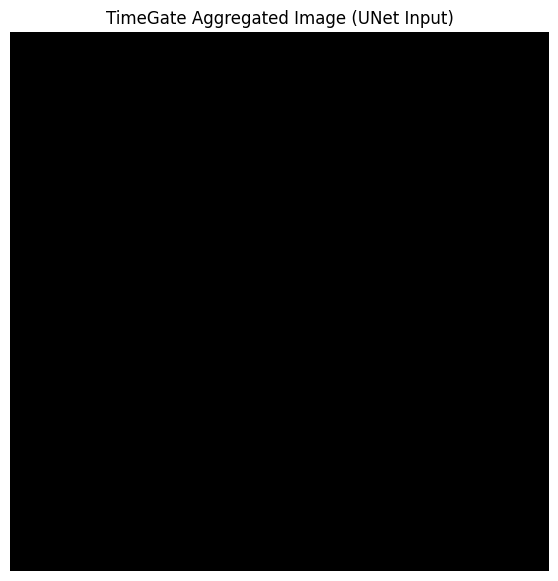

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def to_rgb(img, enhance=2.5):
    rgb = img[0, [2,1,0], :, :].cpu().numpy().transpose(1,2,0)
    rgb = np.clip(rgb * enhance, 0, 1)
    return rgb

plt.figure(figsize=(7,7))
plt.imshow(to_rgb(aggregated_img))
plt.title("TimeGate Aggregated Image (UNet Input)")
plt.axis("off")
plt.show()

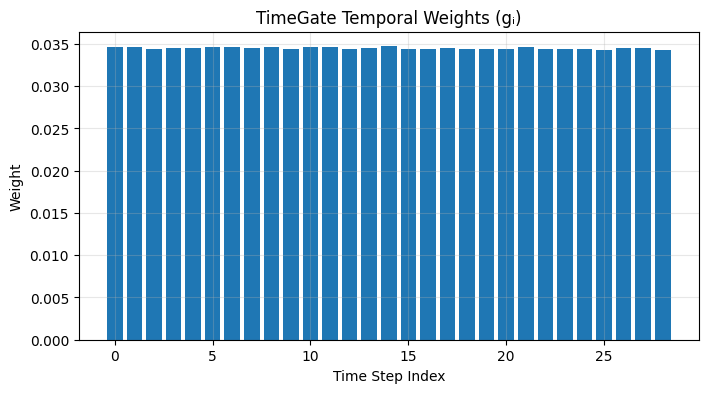

In [15]:
weights_np = weights[0].cpu().numpy()

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(weights_np)), weights_np)
plt.title("TimeGate Temporal Weights (gᵢ)")
plt.xlabel("Time Step Index")
plt.ylabel("Weight")
plt.grid(alpha=0.3)
plt.show()